# Paytm

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 500
pio.renderers.default = "png"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/paytm/paytm.csv', engine='python')

In [3]:
# Company username
company_username = 'Paytmcare'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
df = df[~df['date'].str.contains("http", na=False)]

In [6]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [7]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [8]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [10]:
qdf.shape

(3459, 28)

In [11]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 3358


In [12]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [41]:
result_list = []
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result_list.append([conversation_id, response_time])

result = pd.DataFrame(result_list, columns=['conversation_id', 'response_time'])

In [42]:
result[result['response_time']==0]

,conversation_id,response_time


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



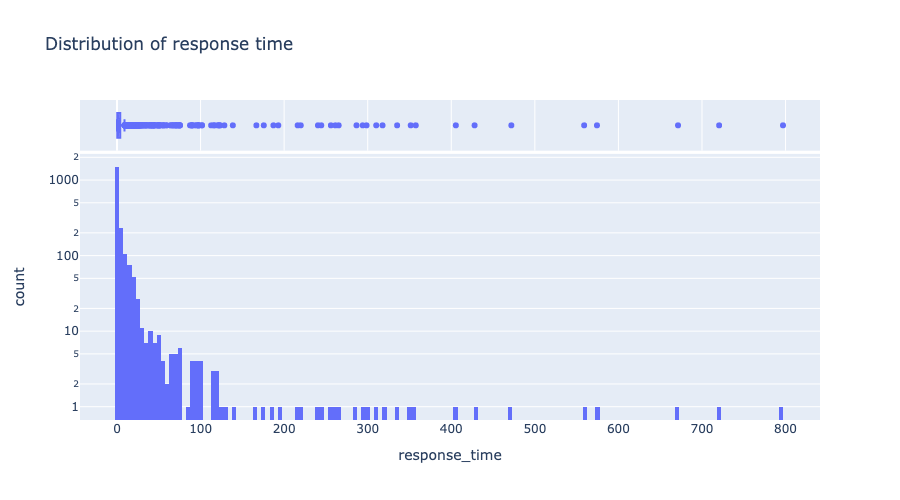

In [43]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [44]:
result['resolution_time'] = 0

In [45]:
unresolved_queries_count = 0
for index, row in result.iterrows():
    tmp = df[df['conversation_id'] == row['conversation_id']]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        if tmp.iloc[-1]['username'] == company_username:
            resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
            result.at[index, 'resolution_time'] = resolution_time

In [46]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 1743
Number of queries unresolved: 352


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



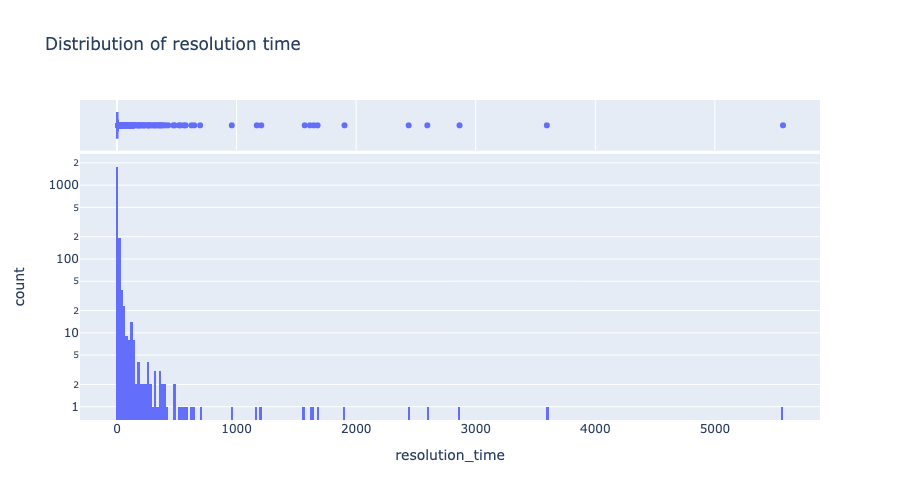

In [47]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [48]:
result.describe()

,response_time,resolution_time
count,2095.000000,2095.000000
mean,14.301693,26.346499
std,105.813474,204.460508
min,0.006389,0.000000
25%,0.300000,0.146528
50%,0.799167,0.643056
75%,3.823194,3.830000
max,3356.318056,5569.472222


In [40]:
result.to_csv('./../../../../outputs/time_data/paytm.csv', index=False)

## Query Tweets Topics

In [22]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape


(2070, 28)

In [23]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [24]:
pre_queries.shape


(1394, 31)

In [25]:
post_queries.shape


(548, 31)

In [26]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)


Pre-COVID coherence Score:  -4.824127277418148


In [27]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008007 -0.112150       1        1  28.743868
2      0.084665  0.047375       2        1  24.130313
0     -0.107675  0.049881       3        1  23.795276
3      0.031018  0.014894       4        1  23.330542, topic_info=         Term        Freq       Total Category  logprob  loglift
56     wallet  100.000000  100.000000  Default  30.0000  30.0000
33   cashback   60.000000   60.000000  Default  29.0000  29.0000
242    refund   79.000000   79.000000  Default  28.0000  28.0000
304   balance   48.000000   48.000000  Default  27.0000  27.0000
291  postpaid  260.000000  260.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
33   cashback   14.851557   60.718311   Topic4  -5.5016   0.0473
54    service   15.483568   72.149917   Topic4  -5.4600  -0.0836
737   working   14.662030   66.724934   Topic4  -5.5145  -0.0599
264       pay   13.273674   77.107321   Topic4  -5.6140  -0.3040
158      days   13.082507   69.512187   Topic4  -5.6285  -0.2148

[298 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
518       1  0.399073    able
518       2  0.537881    able
518       3  0.017351    able
518       4  0.034702    able
945       4  0.743177     acc
...     ...       ...     ...
239       3  0.602138    year
239       4  0.100356    year
40        1  0.153135  zomato
40        2  0.153135  zomato
40        3  0.650823  zomato

[574 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [28]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

In [29]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['postpaid, card, days, payment, received, membership, app, team, working, fraud',
       'app, account, kyc, payment, time, postpaid, money, pay, limit, ticket',
       'postpaid, wallet, payment, help, cashback, account, balance, order, able, money',
       'postpaid, refund, money, issue, use, payment, dont, help, offer, recharge'],
      dtype=object)

Pre-COVID following topics can be seen:
1. Paytm postpaid issues
2. KYC issues
3. Wallet and cashback issues
4. Payment related issues on third-party sites

In [30]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



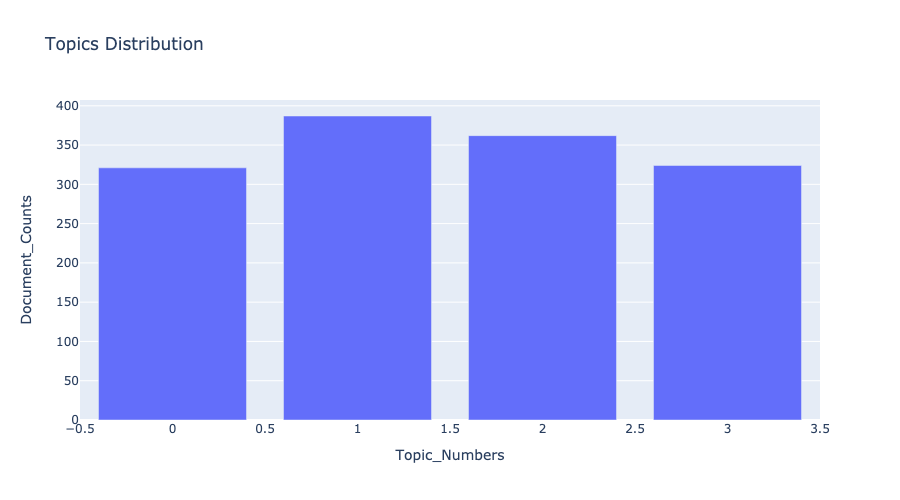

In [31]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()


In [32]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


Post-COVID coherence Score:  -6.9671711201971975


In [33]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099795  0.018061       1        1  43.618505
1      0.032606 -0.087206       2        1  32.617606
0      0.067190  0.069145       3        1  23.763888, topic_info=            Term        Freq       Total Category  logprob  loglift
242     postpaid  112.000000  112.000000  Default  30.0000  30.0000
9        account   64.000000   64.000000  Default  29.0000  29.0000
27           app   59.000000   59.000000  Default  28.0000  28.0000
50        offers   11.000000   11.000000  Default  27.0000  27.0000
216          use   41.000000   41.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
106      payment    6.677754   52.628320   Topic3  -5.3584  -0.6275
148  transaction    4.845914   15.104093   Topic3  -5.6790   0.3002
129     customer    5.118940   25.314168   Topic3  -5.6242  -0.1614
54         money    5.011474   57.104473   Topic3  -5.6454  -0.9961
245       unable    4.596419   18.304968   Topic3  -5.7319   0.0551

[222 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
287       1  0.304872       ac
287       2  0.685962       ac
1457      2  0.987177      acc
9         1  0.885598  account
9         2  0.108758  account
...     ...       ...      ...
537       1  0.621419     want
537       3  0.345233     want
418       2  0.987261  writing
108       2  0.343482   zomato
108       3  0.686964   zomato

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [34]:

post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())



In [35]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['postpaid, account, money, use, payment, app, pay, option, service, hey',
       'wallet, recharge, payment, postpaid, showing, paid, card, help, service, app',
       'app, offer, offers, credit_card, received, got, dont, food, option, membership'],
      dtype=object)

Following topics were discussed post pandemic:
1. Postpaid related issues
2. Wallet related issues
3. Offer related issues

In [36]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



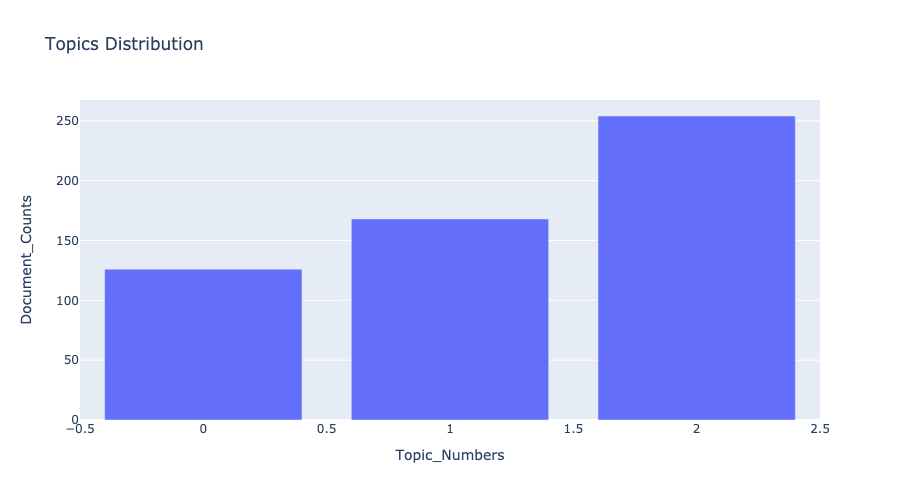

In [37]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()
